<a href="https://colab.research.google.com/github/roshanraii/covid-19-chest-x-ray-image-classifier/blob/main/Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai.metrics import error_rate
import warnings
warnings.filterwarnings("ignore")

In [ ]:
bs=24

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"roshanraii","key":"7ba5c08ff722f462693fc125e9b357d1"}'}

In [ ]:
import os
import pandas as pd
cred = pd.read_json("kaggle.json",lines=True)
os.environ['KAGGLE_USERNAME'] = cred.iloc[0][0]
os.environ['KAGGLE_KEY'] = cred.iloc[0][1]

In [ ]:
!kaggle datasets download -d roshanraii/covid-chest-xray

100% 1.31G/1.31G [00:16<00:00, 93.6MB/s]
100% 1.31G/1.31G [00:16<00:00, 86.2MB/s]


In [ ]:
!mkdir chestxray

In [ ]:
!unzip covid-chest-xray.zip -d chestxray

Streaming output truncated to the last 5000 lines.
  inflating: chestxray/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chestxray/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chestxray/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chestxray/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chestxray/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chestxray/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chestxray/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chestxray/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chestxray/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chestxray/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chestxray/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chestxray/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chestxray/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chestxray/chest_xray/train/NORMAL/IM-0446-000

In [ ]:
path ="/content/chestxray/chest_xray/train"

In [ ]:
classes = ['COVID-19','NORMAL','PNEUMONIA']

In [ ]:
for c in classes:
    print(c)
    verify_images(path+"/"+c, delete=True, max_size=1000)

COVID-19


NORMAL


PNEUMONIA


In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
data.classes 

['COVID-19', 'NORMAL', 'PNEUMONIA']

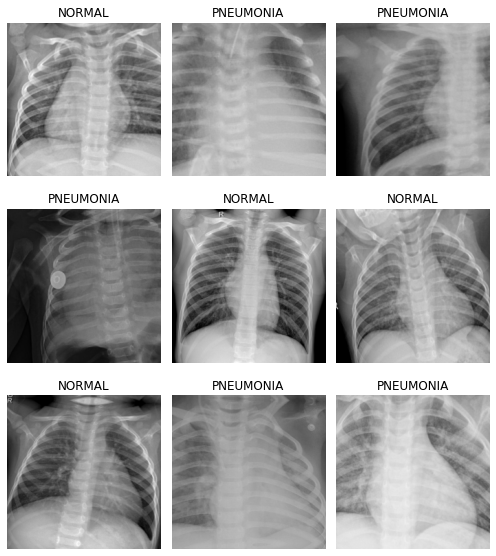

In [ ]:
data.show_batch(rows=3, figsize=(7,8))

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['COVID-19', 'NORMAL', 'PNEUMONIA'], 3, 4406, 1101)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.657717,0.492511,0.089010,03:05
1,0.369069,0.220998,0.062670,03:04
2,0.236516,0.196858,0.049046,03:06
3,0.177075,0.183704,0.052679,03:06


In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


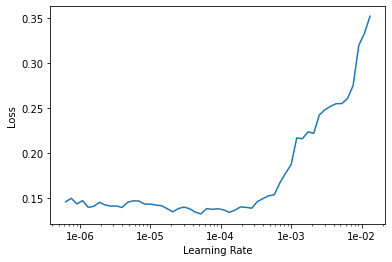

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.143034,0.116499,0.034514,03:06
1,0.132577,0.175132,0.039055,03:05
2,0.097339,0.103158,0.030881,03:04
3,0.073548,0.124658,0.037239,03:06


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

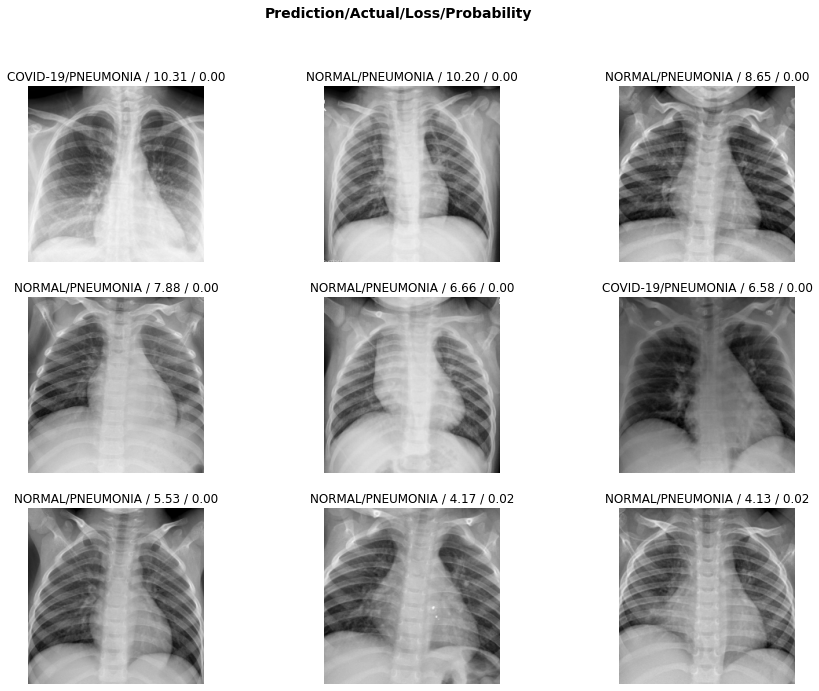

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
doc(interp.plot_top_losses)

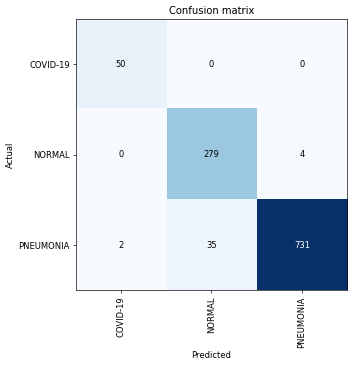

In [ ]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [ ]:
os.makedirs("/content/drive/My Drive/dl_projects/chestxray",exist_ok=True)

In [ ]:
my_dir="/content/drive/My Drive/dl_projects/chestxray"

In [ ]:
learn.save(my_dir+"/Stage-1")

In [ ]:
learn.load("/content/drive/My Drive/dl_projects/chestxray/Stage-1")

Learner(data=ImageDataBunch;

Train: LabelList (4406 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA
Path: /content/chestxray/chest_xray/train;

Valid: LabelList (1101 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,PNEUMONIA,NORMAL,NORMAL,PNEUMONIA
Path: /content/chestxray/chest_xray/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn

In [ ]:
learn.export(my_dir+"/export.pkl")